<a href="https://colab.research.google.com/github/ConanOReilly/Final_Year_Project/blob/main/Image_Data/DenseNet121FinalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DenseNet121 Final Model**
The fine-tuned DenseNet121, with Focal Loss and Scheduled Learnning, will now be trained for 50 epochs, with a patience of 5.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Libraries**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# **Pre-processing and Defining Model**

In [ ]:
metadata_path = "/content/drive/MyDrive/Final Year Project/Data/PAD/Metadata/metadata.csv"
image_dir = "/content/drive/MyDrive/Final Year Project/Data/PAD/imgs"

metadata_df = pd.read_csv(metadata_path)
label_encoder = LabelEncoder()
metadata_df["label_encoded"] = label_encoder.fit_transform(metadata_df["diagnostic"].str.upper())
class_names = label_encoder.classes_
num_classes = len(class_names)

train_df, val_df = train_test_split(metadata_df, test_size=0.2, stratify=metadata_df["label_encoded"], random_state=42)

In [ ]:
img_size = 224
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class SkinCancerDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row["img_id"])
        image = Image.open(img_path).convert("RGB")
        label = row["label_encoded"]
        if self.transform:
            image = self.transform(image)
        return image, label

train_dataset = SkinCancerDataset(train_df, image_dir, transform=train_transforms)
val_dataset = SkinCancerDataset(val_df, image_dir, transform=val_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(metadata_df["label_encoded"]), y=metadata_df["label_encoded"])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()


def train_with_focal_loss_only(model, train_loader, val_loader, device, class_weights_tensor,
                               num_epochs=50, patience=5, save_path="/content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_ensembled_focal_sched_50_epochs.pth"):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    criterion = FocalLoss(weight=class_weights_tensor.to(device), gamma=2.0)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

    best_val_loss = float('inf')
    early_stop_counter = 0
    best_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = F.cross_entropy(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= total
        val_acc = correct / total
        current_lr = optimizer.param_groups[0]['lr']

        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.6f}")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["lr"].append(current_lr)

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            best_epoch = epoch
            torch.save(model.state_dict(), save_path)
            print(f"Saved best model to: {save_path}")
        else:
            early_stop_counter += 1
            print(f"Early stop counter: {early_stop_counter}/{patience}")

        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best epoch: {best_epoch+1}")
            break

    return history

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ensembled_model = models.densenet121(weights=None)
ensembled_model.classifier = nn.Linear(ensembled_model.classifier.in_features, num_classes)
model_path = "/content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_ensembled_focal_sched.pth"
ensembled_model.load_state_dict(torch.load(model_path, map_location=device))
ensembled_model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

**Training Model**

In [ ]:
history = train_with_focal_loss_only(
    model=ensembled_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    class_weights_tensor=class_weights_tensor,
    num_epochs=50,
    patience=5,
    save_path=model_path
)
print("\nTraining complete.")


Epoch 1/50


Train Acc: 0.7639 | Val Acc: 0.6543 | Val Loss: 0.9567 | LR: 0.000100
Saved best model to: /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_ensembled_focal_sched.pth

Epoch 2/50


Train Acc: 0.8030 | Val Acc: 0.6457 | Val Loss: 0.9421 | LR: 0.000100
Saved best model to: /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_ensembled_focal_sched.pth

Epoch 3/50


Train Acc: 0.8254 | Val Acc: 0.6696 | Val Loss: 0.9251 | LR: 0.000100
Saved best model to: /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_ensembled_focal_sched.pth

Epoch 4/50


Train Acc: 0.8564 | Val Acc: 0.6717 | Val Loss: 0.9072 | LR: 0.000100
Saved best model to: /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_ensembled_focal_sched.pth

Epoch 5/50


Train Acc: 0.8781 | Val Acc: 0.6891 | Val Loss: 0.8706 | LR: 0.000100
Saved best model to: /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_ensembled_focal_sched.pth

Epoch 6/50


Train Acc: 0.8896 | Val Acc: 0.6783 | Val Loss: 0.8564 | LR: 0.000100
Saved best model to: /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_ensembled_focal_sched.pth

Epoch 7/50


Train Acc: 0.9048 | Val Acc: 0.6826 | Val Loss: 0.8237 | LR: 0.000100
Saved best model to: /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_ensembled_focal_sched.pth

Epoch 8/50


Train Acc: 0.8955 | Val Acc: 0.6891 | Val Loss: 0.8600 | LR: 0.000100
Early stop counter: 1/5

Epoch 9/50


Train Acc: 0.9086 | Val Acc: 0.7130 | Val Loss: 0.8333 | LR: 0.000100
Early stop counter: 2/5

Epoch 10/50


Train Acc: 0.9097 | Val Acc: 0.6891 | Val Loss: 0.8155 | LR: 0.000100
Saved best model to: /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_ensembled_focal_sched.pth

Epoch 11/50


Train Acc: 0.9157 | Val Acc: 0.6478 | Val Loss: 0.9239 | LR: 0.000100
Early stop counter: 1/5

Epoch 12/50


Train Acc: 0.9233 | Val Acc: 0.7391 | Val Loss: 0.7850 | LR: 0.000100
Saved best model to: /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_ensembled_focal_sched.pth

Epoch 13/50


Train Acc: 0.9336 | Val Acc: 0.7261 | Val Loss: 0.7947 | LR: 0.000100
Early stop counter: 1/5

Epoch 14/50


Train Acc: 0.9499 | Val Acc: 0.7413 | Val Loss: 0.7421 | LR: 0.000100
Saved best model to: /content/drive/MyDrive/Final Year Project/Code/Image Classification/DenseNet121/densenet121_ensembled_focal_sched.pth

Epoch 15/50


Train Acc: 0.9489 | Val Acc: 0.7087 | Val Loss: 0.7737 | LR: 0.000100
Early stop counter: 1/5

Epoch 16/50


Train Acc: 0.9314 | Val Acc: 0.7457 | Val Loss: 0.7816 | LR: 0.000100
Early stop counter: 2/5

Epoch 17/50


Train Acc: 0.9679 | Val Acc: 0.7109 | Val Loss: 0.7711 | LR: 0.000100
Early stop counter: 3/5

Epoch 18/50


Train Acc: 0.9690 | Val Acc: 0.7435 | Val Loss: 0.7640 | LR: 0.000050
Early stop counter: 4/5

Epoch 19/50


Train Acc: 0.9684 | Val Acc: 0.7283 | Val Loss: 0.7559 | LR: 0.000050
Early stop counter: 5/5
⏹️ Early stopping at epoch 19. Best epoch: 14

Training complete.


# **Evaluation**

In [ ]:
def plot_training_curves(history, title_prefix=""):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Learning Rate
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['lr'], label='Learning Rate')
    plt.title(f'{title_prefix} Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('LR')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_model(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45)
    plt.tight_layout()
    plt.show()

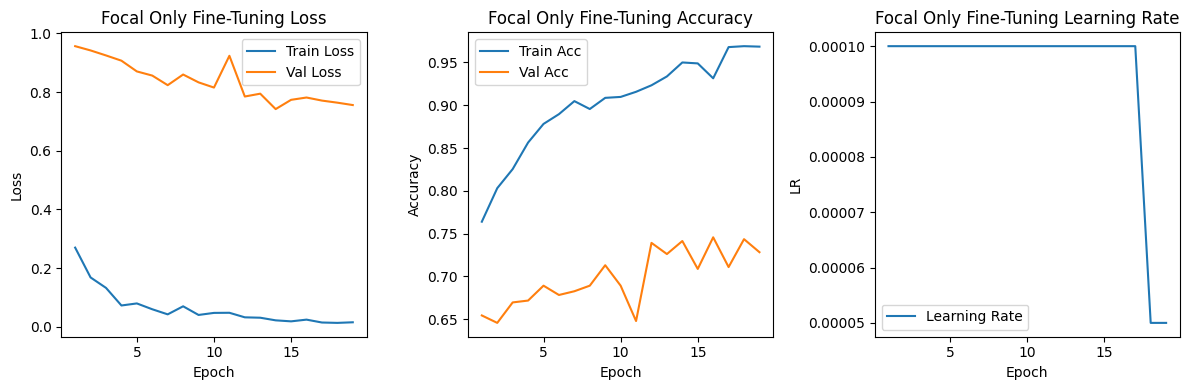

Classification Report:

              precision    recall  f1-score   support

         ACK       0.78      0.82      0.80       146
         BCC       0.85      0.66      0.74       169
         MEL       0.75      0.90      0.82        10
         NEV       0.70      0.78      0.74        49
         SCC       0.39      0.62      0.48        39
         SEK       0.69      0.72      0.71        47

    accuracy                           0.73       460
   macro avg       0.69      0.75      0.71       460
weighted avg       0.76      0.73      0.73       460



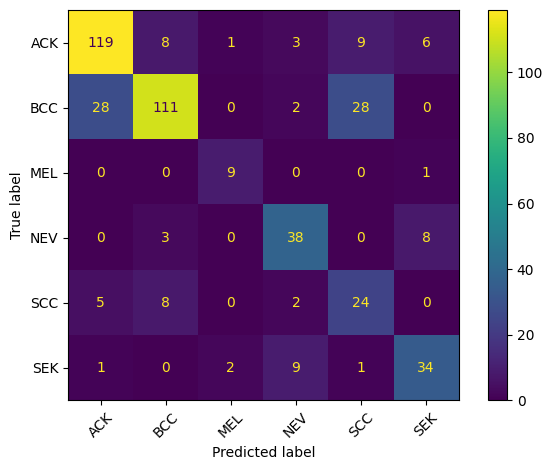

In [ ]:
# Plot training curves
plot_training_curves(history, title_prefix="Focal Only Fine-Tuning")

# Evaluate on validation set
evaluate_model(ensembled_model, val_loader, class_names, device)

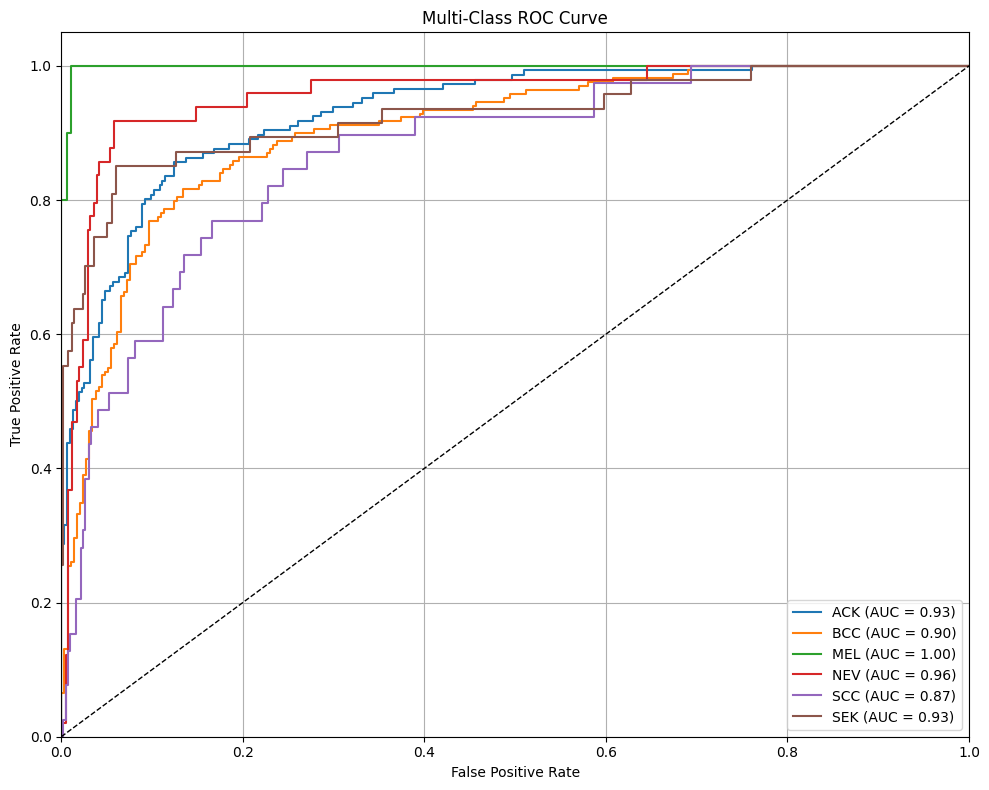

In [ ]:
# Collect predictions and true labels
y_true = []
y_scores = []

ensembled_model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = ensembled_model(images)
        probs = F.softmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

# Binarize labels
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
y_scores = np.array(y_scores)

# Compute ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()